# Mask R-CNN - Inspect BDD Trained Model

Code to analyze results on drivable area detection results.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.bdd import bdd

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


## Configurations

In [2]:
config = bdd.BddConfig()
BDD_DIR = os.path.join(ROOT_DIR, "datasets/bdd")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  200
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = bdd.BddDataset()
dataset.load_bdd(BDD_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10000
Classes: ['BG', 'drivableArea']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [8]:
# Set path to bdd weights file

weights_path = "../../logs/imgpgpu4_val10k_train100k20181215T2133/mask_rcnn_imgpgpu4_val10k_train100k_0092.h5"
# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ../../logs/imgpgpu4_val10k_train100k20181215T2133/mask_rcnn_imgpgpu4_val10k_train100k_0092.h5
Re-starting from epoch 92


## Run Detection

image ID: bdd.c8317cdd-1703e2a7.jpg (0) /home/ubuntu/Mask_RCNN/datasets/bdd/val/c8317cdd-1703e2a7.jpg
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  255.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


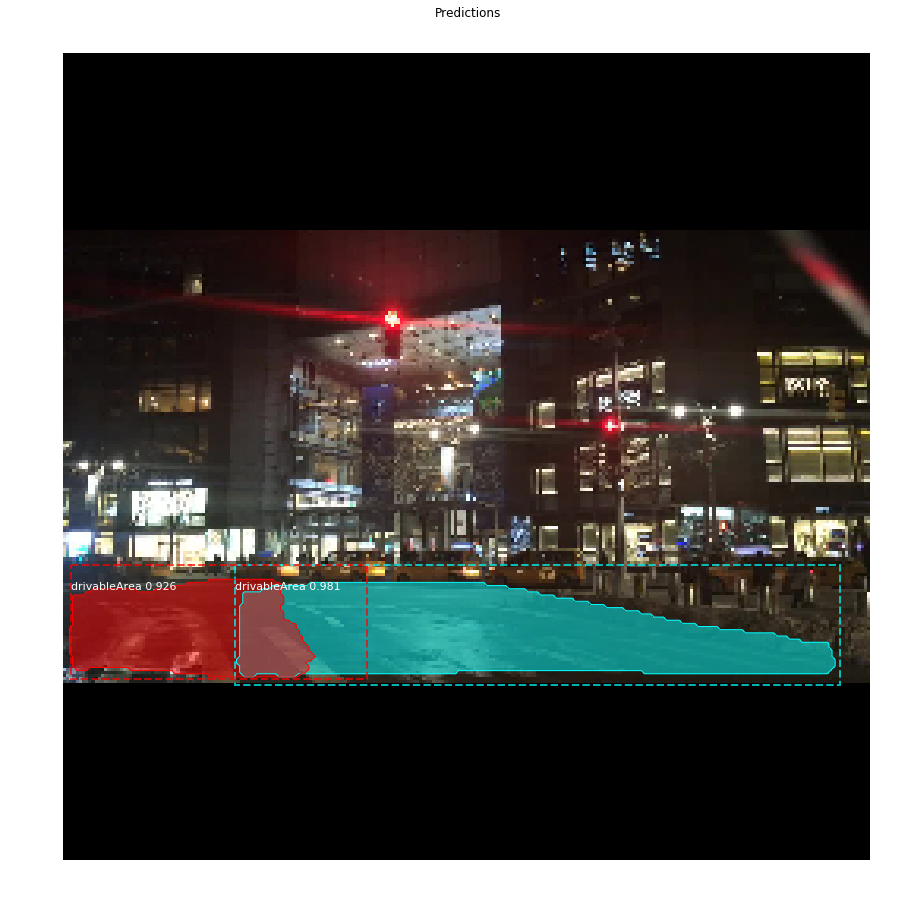

In [9]:
count=0 #Set this to number of images that you want to visualize 
for image_id in dataset.image_ids:    
    if (count>0):
        break
    #image_id = random.choice(dataset.image_ids)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)
    count=count+1
   

## IOU Metric Calculation 

In [10]:
#We calculate the IoU metric for each image 
#We calculate average IoU metric over the enitre validation dataset
count=0 #Counts the total number of images
count_wMask=0
img_nullMask=[]
img_highIoU=[]
iou=[]
for image_id in dataset.image_ids:
    if (count>=500):
        break
    count=count+1
    #image_id = random.choice(dataset.image_ids)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    r['masks']=np.sum(r['masks'],axis=2)
    gt_mask=np.sum(gt_mask,axis=2)
    intersection=np.logical_and(r['masks'],gt_mask)
    union=np.logical_or(r['masks'],gt_mask)
    if np.sum(union)!=0:
        iou_score=np.sum(intersection) / np.sum(union)
        iou.append(iou_score)
        count_wMask=count_wMask+1
        if iou_score==0:
            img_nullMask.append(image_id)
        if iou_score>0.9:
            img_highIoU.append(image_id)
        if count%1000==0: #Print IoU for every 1000th image to track progress 
            print ("Image number ",count)
            print ("Filename: ",info["id"]," IoU = ",iou_score)
    #else:                               #***enable to print images with no gt or detected mask 
    #    print (count,np.sum(r['masks']),np.sum(gt_mask))
print ('Total number of images= ',count)
print ('images with no drivable area in ground truth and detection= ',count-count_wMask)
print ('images with drivable area= ',count_wMask)
print ('Average IoU for ',count_wMask,'images with drivable area = ',sum(iou)/(count_wMask))
print ('images with no generated mask or ground truth mask = ',len(img_nullMask))
print ('images with IoU >0.9 ',img_highIoU)

Total number of images=  500
images with no drivable area in ground truth and detection=  12
images with drivable area=  488
Average IoU for  488 images with drivable area =  0.6357108026485659
images with no generated mask or ground truth mask =  21
images with IoU >0.9  [26, 353]


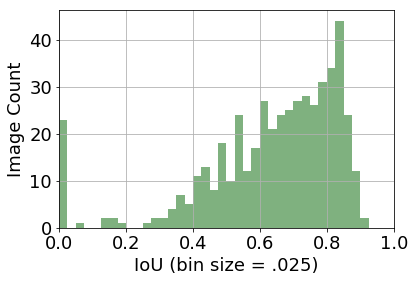

In [11]:
#Plot histogram of IoU metric of validation data images 
import numpy as np
import random
from matplotlib import pyplot as plt

data = np.asarray(iou) 

# fixed bin size
bins = np.arange(0, 1, .025) # fixed bin size
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.xlim(0, 1)
plt.grid(axis='both')
plt.hist(data, bins=bins, alpha=0.5, color='darkgreen')
#plt.title('Histogram of IoU')
plt.xlabel('IoU (bin size = .025)',fontsize=18)
plt.ylabel('Image Count',fontsize=18)


plt.show()

image ID: bdd.b37693d0-cd9bdf88.jpg (353) /home/ubuntu/Mask_RCNN/datasets/bdd/val/b37693d0-cd9bdf88.jpg
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  196.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


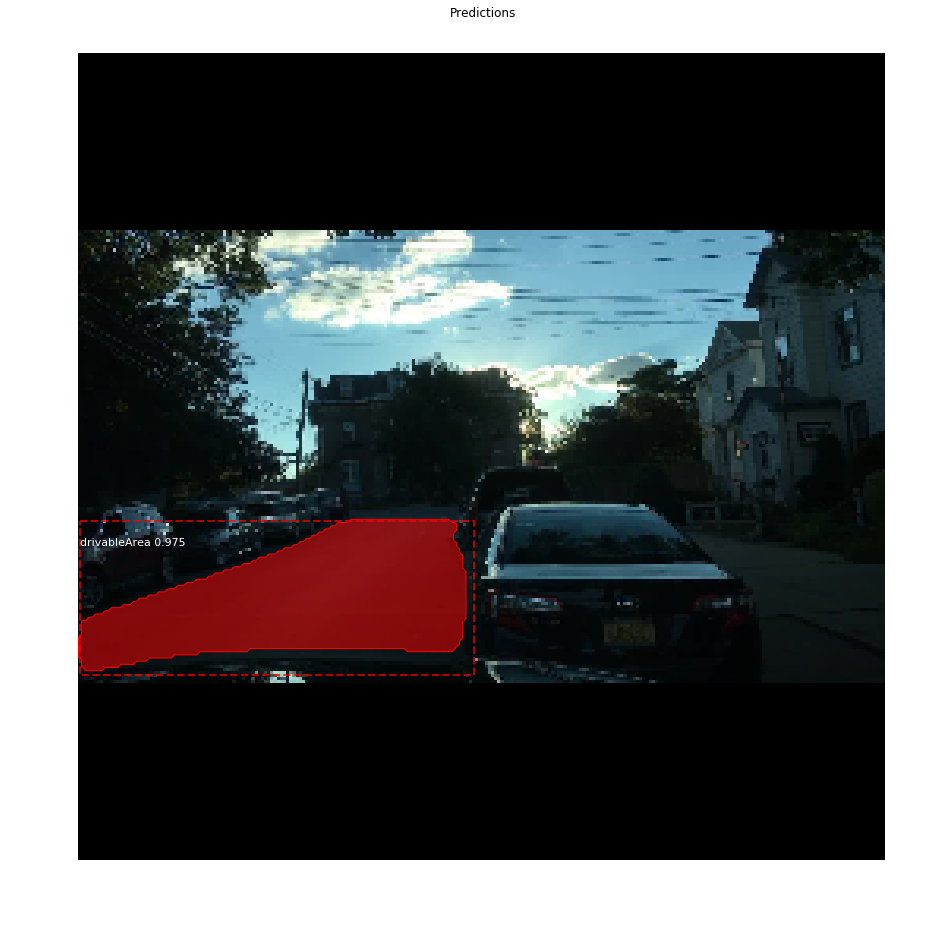

In [12]:
#To Choose a random image from the list of images giving IoU=0, set img=img_nullMask) 
#To Choose a random image from the list of images giving IoU>0.9, set img=img_highIoU)
#Run to display the segmentation result on it.
img=img_highIoU
image_id = random.choice(img)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                      dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)